<a href="https://colab.research.google.com/github/NicoZenith/ComputerVision/blob/main/Normalizing_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.datasets as Dataset
import torchvision.transforms as transforms
from torch.distributions.multivariate_normal import MultivariateNormal
import os
import matplotlib.pyplot as plt


In [ ]:
data_dir = 'data'
os.mkdir(data_dir)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])
dataset = Dataset.MNIST(data_dir, train=True, transform=transform, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 84436032.28it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 103800937.30it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 25290876.70it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1079655.92it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:

batch_size = 64

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
from sklearn.datasets import make_moons

In [ ]:
class Forward(nn.Module):
    def __init__(self, k, sig_net, mu_net):
        super(Forward, self).__init__()
        self.k = k
        self.sig_net = sig_net
        self.mu_net = mu_net


    def forward(self, x):
        x_0k = x[:,:self.k]
        x_kd = x[:,self.k:]
        z_0k = x_0k
        sig = self.sig_net(x_0k)
        mu = self.mu_net(x_0k)
        z_kd = x_kd * torch.exp(sig) + mu
        log_jacob = sig.sum(-1)
        return torch.cat((z_0k, z_kd), dim=1), log_jacob

class Inverse(nn.Module):
    def __init__(self, k, sig_net, mu_net):
        super(Inverse, self).__init__()
        self.k = k
        self.sig_net = sig_net
        self.mu_net = mu_net

    def forward(self, z):
        z_0k = z[:,:self.k]
        z_kd = z[:,self.k:]
        x_0k = z_0k
        x_kd = (z_kd - self.mu_net(z_0k)) * torch.exp(-self.sig_net(z_0k))
        return torch.cat((x_0k, x_kd), dim=1)

class Sigma(nn.Module):
    def __init__(self, k, d, hidden):
        super(Sigma, self).__init__()
        self.fc1 = nn.Linear(k, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, d-k)

        self.relu = nn.LeakyReLU()

    def forward(self, x_0k):
        output = self.relu(self.fc1(x_0k))
        output = self.relu(self.fc2(output))
        output = self.relu(self.fc3(output))
        output = self.fc4(output)
        return output


class Mu(nn.Module):
    def __init__(self, k, d, hidden):
        super(Mu, self).__init__()
        self.fc1 = nn.Linear(k, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, d-k)

        self.relu = nn.LeakyReLU()

    def forward(self, x_0k):
        output = self.relu(self.fc1(x_0k))
        output = self.relu(self.fc2(output))
        output = self.relu(self.fc3(output))
        output = self.fc4(output)
        return output

class Flow(nn.Module):
    def __init__(self, n, k, mu_net, sig_net):
        super(Flow, self).__init__()

        self.fwd = Forward(k, mu_net, sig_net)
        self.n = nn
        # for i in range(n-1):
        #     list_layers.append(Forward(k, mu_net, sig_net))
        # self.flow = nn.Sequential(*list_layers)

    def forward(self, x):
        output, log_j = self.fwd(x)
        log_jacobs = [log_j]

        for i in range(n-1):
            output, log_j = self.fwd(output)
            log_jacobs.append(log_j)

        return output, sum(log_jacobs)


class Inverse_Flow(nn.Module):
    def __init__(self, n, k, mu_net, sig_net):
        super(Inverse_Flow, self).__init__()
        list_layers = nn.ModuleList([Inverse(k, mu_net, sig_net)])
        for i in range(n-1):
            list_layers.append(Inverse(k, mu_net, sig_net))
        self.inverse_flow = nn.Sequential(*list_layers)

    def forward(self, z):
        return self.inverse_flow(z)










In [ ]:
image, label = next(iter(dataloader))
image.shape

torch.Size([64, 1, 28, 28])

In [ ]:
flatten = nn.Flatten()

In [ ]:
flattened_image = flatten(image)

In [ ]:
unflattened = torch.reshape(flattened_image, (64, 1, 28, 28))

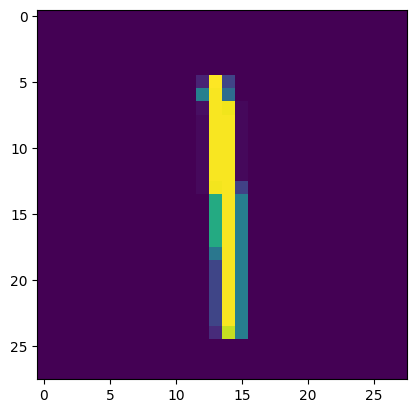

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(unflattened[0].permute(1, 2, 0))

In [ ]:
k = 350
d = 784
mu_net = Mu(k, d, hidden=200)
sig_net = Sigma(k, d, hidden=200)

# output = NN(flattened_image[:, :k])


In [ ]:
from torch.nn.modules import fold
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
k = 350
d = 784
n = 4
mu_net = Mu(k, d, hidden=200)
sig_net = Sigma(k, d, hidden=200)
mu_net.to(device)
sig_net.to(device)



optimizer = torch.optim.Adam(list(mu_net.parameters()) + list(sig_net.parameters()), lr=0.001)

flow = Flow(n, k, mu_net, sig_net)


num_epochs = 5
show_every = 100




In [ ]:
base_mu, base_cov = torch.zeros(784, device=device), torch.eye(784, device=device)
base_dist = MultivariateNormal(base_mu, base_cov)


In [ ]:
for epoch_i in range(0, num_epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_epochs))

    store_loss = []

    flow.train()

    for i, batch in enumerate(dataloader):

        image, _ = batch
        image = image.to(device)

        f_image = flatten(image)

        optimizer.zero_grad()

        output, log_j = flow(f_image)

        log_pz = output**2



        loss =  - torch.mean(log_pz + log_j, dim=-1)

        loss.backward()

        store_loss.append(loss.item())

        optimizer.step()

        # Progress update every x batches.
        if i % show_every == 0 and not i == 0:
            print('  Batch {} / {}.'.format(i, len(dataloader)))
            print('Loss: %.3f '%(np.mean(store_loss)))







======== Epoch 1 / 5 ========


RuntimeError: ignored

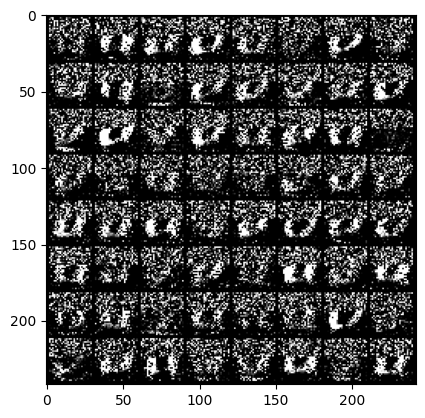

In [ ]:
image, _ = next(iter(dataloader))
f_image = flatten(image).to(device)

inv_flow = Inverse_Flow(n, k, mu_net, sig_net)

with torch.no_grad():
    # output = flow(f_image)
    noise = torch.randn((64, 784), device=device)
    r_f_image = inv_flow(noise)
    r_image = torch.reshape(r_f_image, (64, 1, 28, 28)).cpu()

grid = torchvision.utils.make_grid(r_image, nrow=int(len(r_image)**0.5))
plt.imshow(grid.permute(1, 2, 0))



In [ ]:
noise

tensor([[ 0.1067,  0.7605,  1.9250,  ..., -0.4027, -0.8127,  0.5261],
        [ 0.9033,  0.1927,  0.1140,  ..., -0.9692, -0.1193, -1.5812],
        [ 0.3850,  0.7212, -1.4199,  ..., -0.5017, -0.3785,  0.7630],
        ...,
        [ 1.3930, -1.0657,  1.0732,  ..., -0.2180,  2.1416,  0.3953],
        [-0.3324, -0.6366, -0.1553,  ...,  0.3427,  0.0533,  1.0505],
        [ 0.9675, -0.2581, -1.1904,  ..., -1.0527,  1.5632, -0.9520]],
       device='cuda:0')